In [1]:
import pandas as pd

df = pd.read_csv("../data/review_rating.csv")

In [2]:
len(df)

3420

In [3]:
# 중복되지 않은 데이터 확인
df['1'].nunique(), df['0'].nunique()
# 중복값이 약 700개

(2727, 10)

In [4]:
df.duplicated().sum()

688

In [5]:
#중복값 제거
df.drop_duplicates(inplace=True)
len(df)

2732

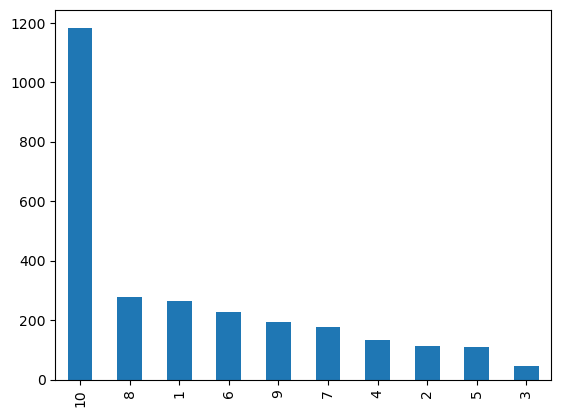

In [6]:
import matplotlib.pyplot as plt
df['0'].value_counts().plot(kind = 'bar')
plt.show()

In [7]:
#특수문자,기호 제거
df['1'] = df['1'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
df[:3]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5492\789926941.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['1'] = df['1'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")


,0,1,2
0,7,어우 의자에 앉아서 스크린으로 보는데도 느껴지는 타격감,범죄도시2
1,8,범죄도시3이 기대돼요,범죄도시2
2,5,범죄도시3가 기대됩니다,범죄도시2


In [8]:
import numpy as np
#공백 제거
df['1'] = df['1'].str.replace('^ +', "")
df['1'].replace('', np.nan, inplace=True)
df.isnull().sum()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5492\3960239143.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['1'] = df['1'].str.replace('^ +', "")


0    0
1    5
2    0
dtype: int64

In [9]:
df.loc[df['1'].isnull()][:3]

,0,1,2
93,10,NaN,스파이더맨: 노 웨이 홈
2049,6,NaN,킹메이커
2209,10,NaN,자백


In [10]:
#null 샘플 제거
df = df.dropna(how = 'any')
len(df)

2727

In [11]:
# 불용어 사전
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [12]:
from sklearn.model_selection import train_test_split

y = df['0']
X = df['1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [13]:
from konlpy.tag import Okt
okt = Okt()
X_train_lis = []
#형태소 분석
for sentence in X_train:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train_lis.append(temp_X)

In [14]:
print(X_train_lis[:3])

[['홍길동', '아니다', '리메이크', '리메이크', '라', '말', '을', '못'], ['기대', '크다', '보다', '90년', '대', '향수', '불러일으키다', '기', '에도', '역', '부족', '이다', '연출', '연기', '아쉬움', '많이', '남다'], ['포스터', '급', '인데', '재미', '급', '코미디', '영화', '기대다', '단', '1', '안', '하고', '보다', '끝', '까지', '웃기다']]


In [15]:
from konlpy.tag import Okt
okt = Okt()
X_test_lis = []
#형태소 분석
for sentence in X_test:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test_lis.append(temp_X)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lis)
#print(tokenizer.word_index)

In [17]:
# 출현빈도가 3회 미만인 단어들
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print(total_cnt) #단어집합 크기
print(rare_cnt) #희귀단어수

5355
3494


In [18]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 1862


In [19]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_lis) #텍스트를 숫자 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(X_train_lis)
X_test = tokenizer.texts_to_sequences(X_test_lis)

In [20]:
print(X_train[:3])

[[23, 440, 440, 145, 58, 3, 50], [95, 122, 1, 1172, 134, 96, 349, 503, 8, 35, 10, 414, 74, 170], [131, 89, 80, 131, 383, 2, 1173, 826, 43, 27, 65, 1, 114, 36, 141]]


In [21]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [22]:
max_len=max(len(l) for l in X_train) #리뷰의 최대 길이

In [23]:
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
#최대 길이 이하인 샘플의 비율
(cnt / len(X_train))*100

91.0132966529115

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [32]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         186200    
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 303,577
Trainable params: 303,577
Non-trainable params: 0
_________________________________________________________________


In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('../model/review_RNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 26.6646 - acc: 0.0768
Epoch 1: val_acc improved from -inf to 0.07551, saving model to ../model\review_RNN.h5
28/28 [==============================] - 3s 34ms/step - loss: 26.6646 - acc: 0.0768 - val_loss: 9.1457 - val_acc: 0.0755
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 9.7645 - acc: 0.1015
Epoch 2: val_acc did not improve from 0.07551
28/28 [==============================] - 0s 17ms/step - loss: 9.7645 - acc: 0.1015 - val_loss: 8.9112 - val_acc: 0.0755
Epoch 3/10
25/28 [=========================>....] - ETA: 0s - loss: 9.6016 - acc: 0.0994
Epoch 3: val_acc did not improve from 0.07551
28/28 [==============================] - 0s 17ms/step - loss: 9.6021 - acc: 0.1015 - val_loss: 8.7580 - val_acc: 0.0755
Epoch 4/10
25/28 [=========================>....] - ETA: 0s - loss: 9.0934 - acc: 0.1000
Epoch 4: val_acc did not improve from 0.07551
28/28 [==============================] - 0s 17ms/step - l

In [34]:
loaded_model = load_model('../model/review_RNN.h5')
loaded_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 9.9161 - acc: 0.0971


[9.9160795211792, 0.09706959873437881]

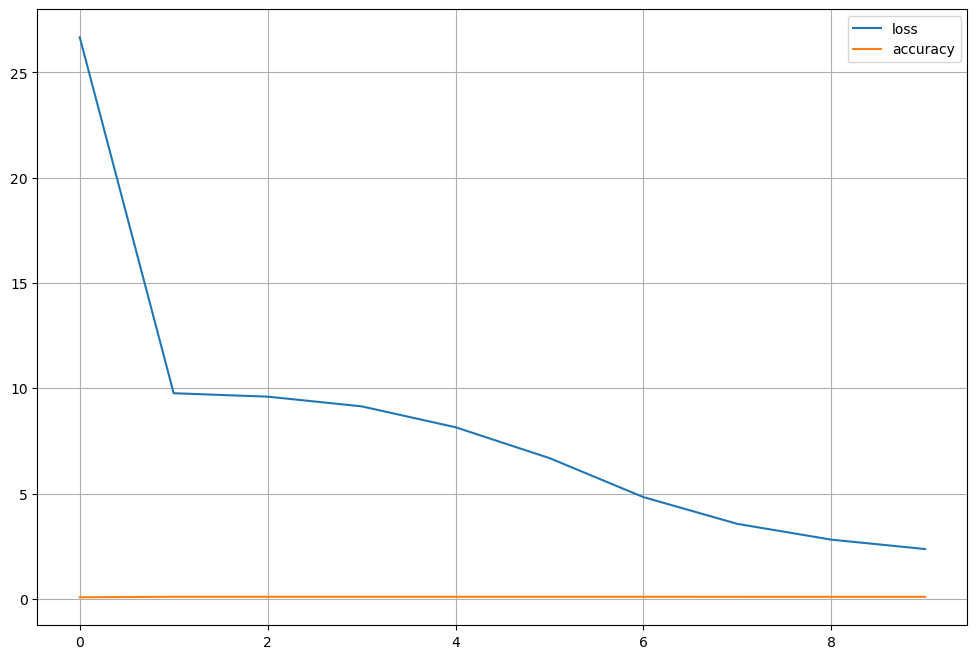

In [35]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['acc']) #정확도
plt.legend(['loss','accuracy'])
plt.grid()
plt.show()